In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
import findspark
import os
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [3]:
def mandelbrot(x, y):
    z = c = complex(x, y)
    iteration = 0
    max_iteration = 511  # arbitrary cutoff
    while abs(z) < 2 and iteration < max_iteration:
        z = z * z + c
        iteration += 1
    return iteration

In [4]:
def sum_values_for_partitions(rdd):
    'Returns (as an RDD) the sum of V for each partition of a (K, V) RDD'
    # note that the function passed to mapPartitions should return a sequence,
    # not a value.
    return rdd.mapPartitions(lambda part: [sum(V for K, V in part)])

In [5]:
def draw_image(rdd):
    '''Given a (K, V) RDD with K = (I, J) and V = count,
    display an image of count at each I, J'''

    data = rdd.collect()
    I = np.array([d[0][0] for d in data])
    J = np.array([d[0][1] for d in data])
    C = np.array([d[1] for d in data])
    im = np.zeros((I.max() + 1, J.max() + 1))
    im[I, J] = np.log(C + 1)  # log intensity makes it easier to see levels
    plt.imshow(im, cmap=cm.gray)
    plt.show()

## Part 2A

In [6]:
coordWidth = 2000
coordHeight = 2000
noPartitions = 100
pixCoordIJ = sc.parallelize([(x, y) for x in range(coordWidth) for y in range(coordHeight)], noPartitions)

In [7]:
print pixCoordIJ
print pixCoordIJ.getNumPartitions()
print pixCoordIJ.take(1)

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:391
100
[(0, 0)]


In [8]:
pixMandel = pixCoordIJ.map(lambda (i, j): ((i, j), mandelbrot(j/500.0 - 2, i/500.0 - 2)))

In [9]:
print pixMandel
print pixMandel.getNumPartitions()
print pixMandel.take(1)

PythonRDD[2] at RDD at PythonRDD.scala:43
100
[((0, 0), 0)]


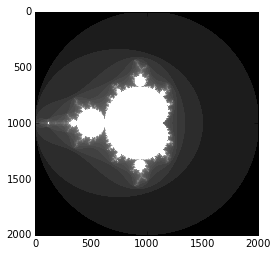

In [10]:
draw_image(pixMandel)

In [11]:
effortMandel = sum_values_for_partitions(pixMandel)

In [12]:
print effortMandel
print effortMandel.getNumPartitions()
print effortMandel.take(10)

PythonRDD[4] at RDD at PythonRDD.scala:43
100
[5101, 9594, 12408, 14639, 16528, 18194, 19680, 20978, 22185, 23334]


In [13]:
partitionWork = effortMandel.collect()

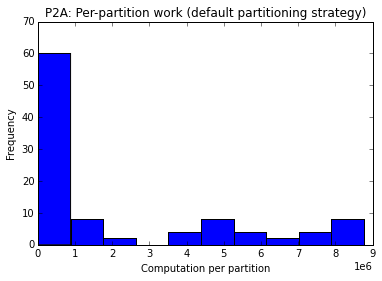

In [14]:
plt.figure()
plt.hist(partitionWork)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Computation per partition')
plt.ylim(0,70)
plt.ylabel('Frequency')
plt.title('P2A: Per-partition work (default partitioning strategy)')
plt.savefig('P2a_hist.png')
plt.show()

## Part 2B

In [15]:
coordWidth = 2000
coordHeight = 2000
noPartitions = 100
pixCoordIJ = sc.parallelize([(x, y) for x in range(coordWidth) for y in range(coordHeight)])

In [16]:
print pixCoordIJ
print pixCoordIJ.getNumPartitions()
print pixCoordIJ.take(1)

ParallelCollectionRDD[8] at parallelize at PythonRDD.scala:391
4
[(0, 0)]


In [17]:
pixMandel = pixCoordIJ.map(lambda (i, j): ((i, j), mandelbrot(j/500.0 - 2, i/500.0 - 2))).partitionBy(noPartitions)

In [18]:
print pixMandel
print pixMandel.getNumPartitions()
print pixMandel.take(1)

MapPartitionsRDD[13] at mapPartitions at PythonRDD.scala:342
100
[((0, 26), 0)]


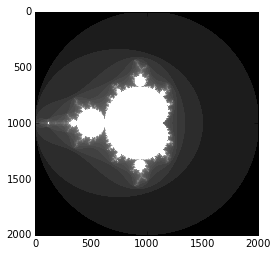

In [19]:
draw_image(pixMandel)

In [20]:
effortMandel = sum_values_for_partitions(pixMandel)

In [21]:
print effortMandel
print effortMandel.getNumPartitions()
print effortMandel.take(10)

PythonRDD[15] at RDD at PythonRDD.scala:43
100
[2031517, 2013430, 2016867, 2022933, 2016007, 2045390, 2043830, 2031820, 2044460, 2026452]


In [22]:
partitionWork = effortMandel.collect()

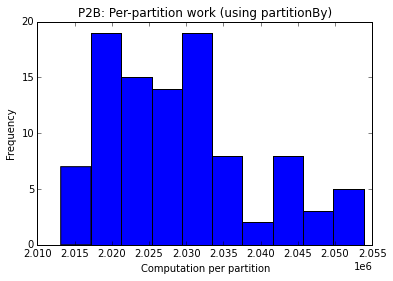

In [23]:
plt.figure()
plt.hist(partitionWork)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Computation per partition')
plt.ylim(0,20)
plt.ylabel('Frequency')
plt.title('P2B: Per-partition work (using partitionBy)')
plt.savefig('P2b_hist.png')
plt.show()